# Implementation of VGG-19

In [ ]:
#@title ##Import stuff

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import tarfile
import os
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
#@title ##Some helper functions

def show_batch(dl):
  """
  takes the dataloader and plots a random batch
  of images as a grid.
  """
  for images, labels in dl:
      fig, ax = plt.subplots(figsize=(12, 6))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
      print(labels)
      break

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
# def accuracy(model, data_loader):
#   """
#   Given a trained model and dataloader
#   computes the accuracy
#   """
#   model.eval()
#   correct_pred, num_examples = 0, 0
#   for i, (features, targets) in enumerate(data_loader):
          
#       features = features.to(DEVICE)
#       targets = targets.to(DEVICE)

#       logits, probas = model(features)
#       _, predicted_labels = torch.max(probas, 1)
#       num_examples += targets.size(0)
#       correct_pred += (predicted_labels == targets).sum()
#   return correct_pred.float()/num_examples * 100

# GPU related functions
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

* ## Downloading & batching data

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
tensor([9, 2, 0, 9, 0, 5, 2, 0, 2, 3, 5, 2, 7, 6, 8, 7, 9, 4, 8, 3, 1, 7, 9, 6,
        1, 1, 2, 0, 6, 2, 9, 8, 0, 2, 5, 8, 2, 1, 9, 7, 4, 0, 6, 5, 3, 6, 7, 9,
        3, 6, 4, 6, 2, 8, 0, 1, 8, 3, 5, 8, 8, 2, 1, 2, 3, 9, 9, 2, 1, 7, 1, 0,
        3, 6, 7, 6, 9, 3, 9, 7, 4, 1, 3, 1, 1, 8, 3, 6, 7, 7, 9, 2, 6, 9, 7, 7,
        9, 0, 6, 1, 5, 6, 5, 3, 7, 7, 2, 3, 6, 4, 1, 4, 6, 4, 0, 2, 1, 9, 2, 1,
        9, 2, 3, 9, 1, 2, 3, 0])


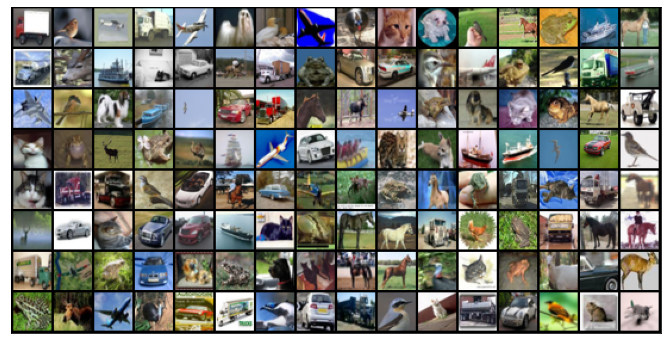

In [ ]:
# Downloading trainset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
# Downloading testset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
# class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# splitting traing data into train & validation set
train_ds, val_ds = random_split(trainset, [45000, 5000])



##########################
### GLOBAL VARS.
##########################
# All the GLOBAL VARIABLES needed are declared here
batch = 128
img, _ = train_ds[0]
input_channels = img.shape[0]
num_classes = len(classes)


# turning all the datasets into batches of data
train_dl = DataLoader(trainset, batch, shuffle=True)
val_dl = DataLoader(val_ds, batch)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False, num_workers=2)

# let's see how 1 batch of data data looks like
show_batch(train_dl)

In [ ]:
#@title ##Loading everything into GPU

# setting device as GPU if available
device = get_default_device()

# Loading the batches of data into GPU
# train_dl = DeviceDataLoader(train_dl, device)
# val_dl = DeviceDataLoader(val_dl, device)

* ## Let's now make the model...

* #### The architecture for our model
<img src = "https://raw.githubusercontent.com/khalidsaifullaah/Classic-Deep-Learning-Models/master/VGGNet/vgg-19-architecture.png" width ="20%" height = "20%" align="center"/>

In [ ]:
# This one is the parent class of our model,
# It holds many basic methods like cost calc, printing result of a model etc.
class Training_Modules(nn.Module):
  def cost(self, batch):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)
    preds = self(imgs)
    loss = F.cross_entropy(preds, labels)
    return loss

  def val_step(self, batch):
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)
    preds = self(imgs)
    loss = F.cross_entropy(preds, labels)
    acc = accuracy(preds, labels)    
    return {'val_loss': loss, 'val_acc': acc}

  def validation_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]   
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def print_result(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
# to make the code much cleaner, making our custom convolution layer
def conv_layer(in_channels, out_channels, pooling = False):
  """
  Returns a CNN layer including non-linearity and pooling if needed
  Following similar design as the authors described in paper i.e.
  kernel = (3x3)
  stride = 1
  padding = 1 (to make spatial dimension same)
  """
  layer_components = [
                      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,padding=1),
                      nn.ReLU()
                      ]
  if pooling:
    layer_components.append(nn.MaxPool2d(2))
  
  return nn.Sequential(*layer_components)

# Here's our architecture in code
class VGG19(Training_Modules):
  def __init__(self, input_channels, num_classes):
    super().__init__()
    
    self.block_1 = nn.Sequential(
        conv_layer(input_channels, out_channels=64),
        conv_layer(64, 64, pooling = True)
    )
    self.block_2 = nn.Sequential(
        conv_layer(64, 128),
        conv_layer(128, 128, pooling = True)
    )
    self.block_3 = nn.Sequential(
        conv_layer(128, 256),
        conv_layer(256, 256),
        conv_layer(256, 256),
        conv_layer(256, 256, pooling = True)
    )
    self.block_4 = nn.Sequential(
        conv_layer(256, 512),
        conv_layer(512, 512),
        conv_layer(512, 512),
        conv_layer(512, 512, pooling = True)
    )
    self.block_5 = nn.Sequential(
        conv_layer(512, 512),
        conv_layer(512, 512),
        conv_layer(512, 512),
        conv_layer(512, 512, pooling = True)
    )

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 4096),
        nn.ReLU(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, num_classes)
    )
    # for m in self.modules():
    #     if isinstance(m, torch.nn.Conv2d):
    #         #n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
    #         #m.weight.data.normal_(0, np.sqrt(2. / n))
    #         m.weight.detach().normal_(0, 0.05)
    #         if m.bias is not None:
    #             m.bias.detach().zero_()
    #     elif isinstance(m, torch.nn.Linear):
    #         m.weight.detach().normal_(0, 0.05)
    #         m.bias.detach().detach().zero_()


  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    x = self.block_5(x)
    logits = self.fc(x)
    return logits

* ## Training & evaluating functions

In [ ]:
def evaluate(model, val_dl):
  with torch.no_grad():
    outputs = [model.val_step(batch) for batch in val_dl]
  return model.validation_end(outputs)


def train(epochs, lr, model, tain_dl, val_dl, opt_fn = torch.optim.Adam):
  running_loss = 0.0
  history = []
  optimizer = opt_fn(model.parameters(), lr)
  for epoch in range(epochs):
    
    total_loss = 0

    for i, batch in enumerate(train_dl):

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      loss = model.cost(batch)
      total_loss+= loss.item()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      
     
    # evaluating the model using validation set
    result = evaluate(model, val_dl)
    model.print_result(epoch, result)
    history.append(result)

   
  return history


In [ ]:
# initializing model
model = VGG19(input_channels, num_classes)

# pushing model to GPU
model = to_device(model, device)

In [ ]:
%%time
history = train(150, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 2.3024, val_acc: 0.0971
CPU times: user 33.2 s, sys: 15.1 s, total: 48.3 s
Wall time: 45.7 s
